In [7]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras
import tensorflow.keras as K
import tensorflow.keras.backend as Kback

from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121, NASNetMobile, EfficientNetB0, Xception
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight


from collections import Counter
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [8]:
base_path = "/kaggle/input/processed-lc25000/LC25000-PP"
class_names =  ["lungadenocarcinoma", "lungbenigntissue", "lungsquamoucellcarcinoma"]


In [9]:
data = []
labels = []

from cv2 import cvtColor
# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as GBR
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        data.append(img)
        labels.append(label)

In [10]:
# data, labels = shuffle(data, labels, random_state=42)


# print('Data length:', len(data))
# print('labels counts:', Counter(labels))

X = np.array(data).reshape(-1, 128, 128, 3)


In [11]:
y = np.array(labels)

In [12]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [13]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=10)
X_test,X_valid,y_test,y_valid=train_test_split(X_, y_, test_size=0.5, random_state=10)




# X_test=X_
# y_test=y_
# X_valid=X_test
# y_valid=y_test


# One-hot encode the labels
num_classes = 3  
# Adjust this based on your dataset
# y_train = to_categorical(y_train, num_classes)
# y_valid = to_categorical(y_valid, num_classes)5
# y_test = to_categorical(y_test, num_classes)
# train_datagen = ImageDataGenerator()
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
# validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

# MobileNetV2

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
base_model.trainable=False

In [16]:

NUM_CLASSES = 3

vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())
dummy_input = tf.zeros((1, 128, 128, 3))
_ = vgg_model(dummy_input)










intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])



vgg_model.add(layers.Dense(256, activation='relu'))


vgg_model.add(layers.Dense(32, activation='relu'))


vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
# vgg_model.layers[0].trainable = False



vgg_model.summary()






# vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

history= vgg_model.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (1, 4, 4, 1280)        │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 20480)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 256)               │     5,243,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 3)                 │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,509,443 (28.65 MB)

 Trainable params: 5,251,459 (20.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
  7/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6127 - loss: 1.1111   

I0000 00:00:1731060340.494255     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1731060340.533049     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8557 - loss: 0.3730

W0000 00:00:1731060349.439294     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8559 - loss: 0.3724 - val_accuracy: 0.9400 - val_loss: 0.1620
Epoch 2/100
  9/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9576 - loss: 0.1335

W0000 00:00:1731060354.300469     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9682 - loss: 0.0881 - val_accuracy: 0.9553 - val_loss: 0.1303
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9861 - loss: 0.0419 - val_accuracy: 0.9540 - val_loss: 0.1330
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9960 - loss: 0.0182 - val_accuracy: 0.9580 - val_loss: 0.1089
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 0.9633 - val_loss: 0.1210
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.9680 - val_loss: 0.0980
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9527 - val_loss: 0.1347
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9933 - loss: 0.0186 - val_accuracy: 0.9667 - val_loss: 0.1224
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy

In [17]:
mode_lfor_evaluation=vgg_model



test_loss, test_accuracy = mode_lfor_evaluation.evaluate(X_test,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9702 - loss: 0.1921
Test Loss: 0.1851891279220581
Test Accuracy: 0.968666672706604


In [18]:
y_pred = vgg_model.predict(X_test, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_2))

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1731060922.383941     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       480
           1       0.98      0.99      0.98       527
           2       0.96      0.98      0.97       493

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



W0000 00:00:1731060925.887090     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<function matplotlib.pyplot.show(close=None, block=None)>

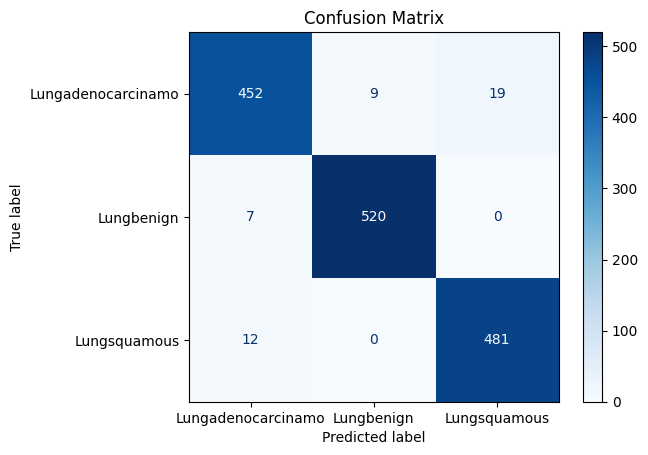

In [19]:
cm= confusion_matrix(y_true=y_test, y_pred=y_pred_2)
target_names = ["Lungadenocarcinamo", "Lungbenign", "Lungsquamous"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

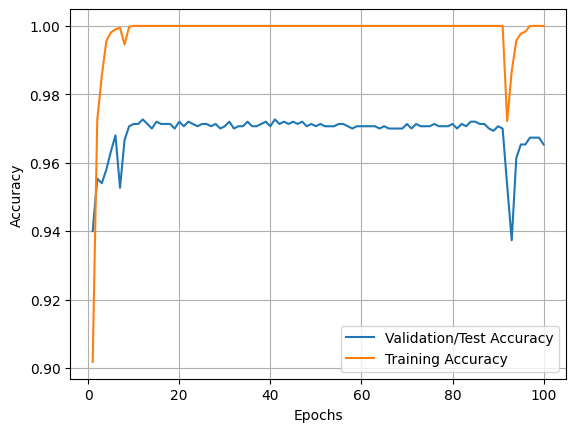

In [20]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

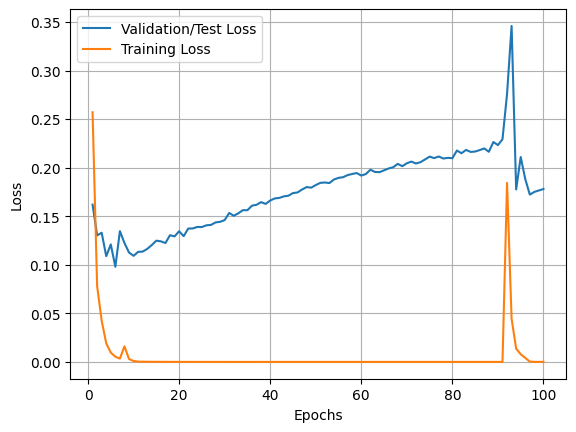

In [21]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
#One vs One
roc_auc_score(y_test, y_pred,multi_class='ovo')

0.9966097584451347

In [23]:
#One vs Rest
roc_auc_score(y_test, y_pred,multi_class='ovr')

0.9966850522171068

# DenseNet121

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)



In [29]:
base_model.trainable=False

In [30]:

NUM_CLASSES = 3

vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())
dummy_input = tf.zeros((1, 128, 128, 3))
_ = vgg_model(dummy_input)










intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])



vgg_model.add(layers.Dense(256, activation='relu'))


vgg_model.add(layers.Dense(32, activation='relu'))


vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
# vgg_model.layers[0].trainable = False



vgg_model.summary()






# vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

history= vgg_model.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (1, 4, 4, 1024)        │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 16384)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 256)               │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 3)                 │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,240,387 (42.88 MB)

 Trainable params: 4,202,883 (16.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
  4/375 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.3529 - loss: 1.6195 

W0000 00:00:1731061306.693025     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8361 - loss: 0.4022

W0000 00:00:1731061327.839334     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.8364 - loss: 0.4015 - val_accuracy: 0.9227 - val_loss: 0.1976
Epoch 2/100
  3/375 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9306 - loss: 0.1657

W0000 00:00:1731061342.551654     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9531 - loss: 0.1292 - val_accuracy: 0.9520 - val_loss: 0.1527
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9663 - loss: 0.0900 - val_accuracy: 0.9327 - val_loss: 0.1777
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9780 - loss: 0.0633 - val_accuracy: 0.9507 - val_loss: 0.1387
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9904 - loss: 0.0367 - val_accuracy: 0.9313 - val_loss: 0.1731
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9910 - loss: 0.0334 - val_accuracy: 0.9520 - val_loss: 0.1379
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9935 - loss: 0.0252 - val_accuracy: 0.9560 - val_loss: 0.1260
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9988 - loss: 0.0114 - val_accuracy: 0.9613 - val_loss: 0.1321
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9982 - loss: 0.0112 - val_

In [31]:
mode_lfor_evaluation=vgg_model



test_loss, test_accuracy = mode_lfor_evaluation.evaluate(X_test,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9627 - loss: 0.2482
Test Loss: 0.2601519525051117
Test Accuracy: 0.9673333168029785


In [32]:
y_pred = vgg_model.predict(X_test, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_2))

 5/47 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

W0000 00:00:1731062596.408487     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       480
           1       0.98      0.98      0.98       527
           2       0.98      0.96      0.97       493

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



W0000 00:00:1731062606.559793     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<function matplotlib.pyplot.show(close=None, block=None)>

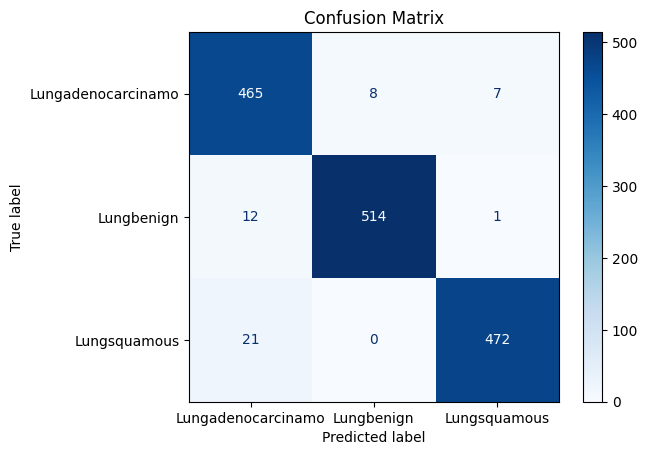

In [33]:
cm= confusion_matrix(y_true=y_test, y_pred=y_pred_2)
target_names = ["Lungadenocarcinamo", "Lungbenign", "Lungsquamous"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

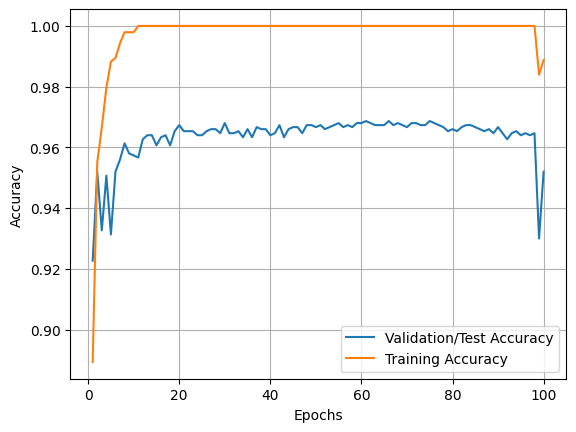

In [34]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

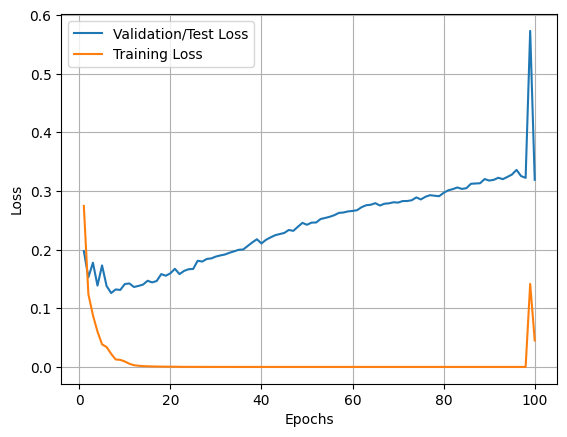

In [35]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [36]:
#One vs One
roc_auc_score(y_test, y_pred,multi_class='ovo')

0.9961705556314655

In [37]:
#One vs Rest
roc_auc_score(y_test, y_pred,multi_class='ovr')

0.9962293114143393

In [ ]:

# NUM_CLASSES = 3

# resnet_model1 = tf.keras.Sequential()
# resnet_model1.add(base_model)
# resnet_model1.add(Flatten())

# resnet_model1.add(layers.Flatten())
# dummy_input = tf.zeros((1, 128, 128, 3))
# _ = resnet_model1(dummy_input)


# intermediate_features = resnet_model1.layers[-1].output
# attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
# attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
# attention_output = layers.Multiply()([intermediate_features, attention_weights])


# resnet_model1.add(Dense(256, activation='relu'))
# # resnet_model.add(layers.Dropout(0.25))
# # resnet_model.add(Dense(256, activation='relu'))
# # vgg_model.add(layers.Dropout(0.25))
# resnet_model1.add(Dense(32, activation='relu'))
# resnet_model1.add(Dense(NUM_CLASSES, activation='softmax'))

# resnet_model1.layers[0].trainable = False




# resnet_model11.summary()




# # vgg_model.summary()

# optimizer=keras.optimizers.Adam(learning_rate=0.0001)
# losses=keras.losses.SparseCategoricalCrossentropy()
# metrics=['accuracy']
# resnet_model1.compile(optimizer=optimizer,loss=losses,metrics=metrics)

# history1= resnet_model1.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))



In [ ]:
# #one line code for all model judgement





# from matplotlib import pyplot as plt
# from sklearn.metrics import classification_report ,confusion_matrix
# import seaborn as sns






# # Put Value of your model here
# mode_lfor_evaluation=resnet_model



# test_loss, test_accuracy = mode_lfor_evaluation.evaluate(test_data)
# print('Test Loss:', test_loss)
# print('Test Accuracy:', test_accuracy)

# import seaborn as sns
# predictions_prob = resnet_model.predict(test_data)
# predictions = np.argmax(predictions_prob , axis = 1)
# true_label = test_data.classes
# report = classification_report(true_label,predictions)
# print(report)

# conf_mat = confusion_matrix(true_label,predictions)
# print("\n\nConfusion Matrix:\n", conf_mat)
# sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
# plt.xlabel('Predictions')
# plt.ylabel('True label')
# plt.title('Confusion Matrix')
# plt.xticks(rotation = 45)
# plt.show()

# print("-----------------------------")


# history_dict = history.history

# acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_accuracy']
# epochs = range(1, len(acc_values) + 1)

# line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
# line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

# plt.setp(line1)
# plt.setp(line2)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.legend()
# plt.show()





# # history_dict = history.history

# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# epochs = range(1, len(loss_values) + 1)

# line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
# line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

# plt.setp(line1)
# plt.setp(line2)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.legend()
# plt.show()







In [ ]:
# optimizer=keras.optimizers.Adam(learning_rate=0.001)
# losses=keras.losses.SparseCategoricalCrossentropy()
# metrics=['accuracy']
# mobilenet_v2_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)